In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation
from torch import nn
from torch.distributions import Categorical, Normal

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

### Utils

In [3]:
def save_frames_as_gif(frames, path="./gifs/", filename="gym_animation.gif", fps=60):
    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer="imagemagick", fps=fps)

In [4]:
def get_trajectory(env, agent, visualize=False, deterministic=True):
    trajectory = {
        "states": [],
        "actions": [],
        "rewards": [],
        "terminated": [],
        "truncated": [],
    }
    frames = []

    obs, _ = env.reset()

    while True:
        action, _ = agent.predict(obs, deterministic=deterministic)
        next_obs, reward, terminated, truncated, _ = env.step(action)

        trajectory["states"].append(obs)
        trajectory["actions"].append(action)
        trajectory["rewards"].append(reward)
        trajectory["terminated"].append(terminated)
        trajectory["truncated"].append(truncated)

        obs = next_obs

        if terminated or truncated:
            break

        if visualize:
            frames.append(env.render())

    if visualize:
        print("saving...")
        save_frames_as_gif(frames)

    return trajectory

In [5]:
def validation(env, agent, validation_n: int = 20, deterministic=False):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, deterministic=deterministic)
        total_rewards.append(np.sum(trajectory["rewards"]))

    return np.mean(total_rewards)

In [6]:
class Logger:
    def __init__(self, log_frequency=1000):
        self.log_frequency = log_frequency
        self.next_iteration = self.log_frequency

    def log(self, steps_n, data):
        if steps_n >= self.next_iteration:
            self.next_iteration += self.log_frequency

            dones = data["terminated"] + data["truncated"]
            if sum(dones) == 0:
                dones[-1] = True
            dones_indeces = dones.nonzero()
            last_done_index = dones_indeces[-1][0].item()
            trajectory_n = sum(dones)
            mean_trajectory_rewards = (
                sum(data["rewards"][:last_done_index]) / trajectory_n
            )
            mean_trajectory_length = last_done_index / trajectory_n
            print(f"steps_n: {steps_n}")
            print(f"mean_trajectory_rewards: {mean_trajectory_rewards}")
            print(f"mean_trajectory_length: {mean_trajectory_length}")

### Stochastic policy

In [7]:
class StochasticMlpPolicy(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super().__init__()
        self.obs_dim = input_size
        self.action_dim = int(output_size / 2)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.act = nn.ReLU()

    def forward(self, input):
        input = torch.FloatTensor(input.reshape(-1, self.obs_dim))
        output = self.act(self.fc1(input))
        output = self.act(self.fc2(output))
        logits = self.fc3(output)
        mu, log_std = logits[:, : self.action_dim], logits[:, self.action_dim :]
        log_std = torch.clamp(log_std, min=-20, max=2)

        return mu, log_std

    def predict(self, input, deterministic=False):
        mu, log_std = self.forward(input)
        dist = Normal(mu, torch.exp(log_std))

        if deterministic:
            action = mu
        else:
            action = dist.sample()

        log_prob_action = dist.log_prob(action)
        action = action.numpy().reshape(self.action_dim)

        return action, log_prob_action

In [8]:
class DiscreteStochasticMlpPolicy(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64):
        super().__init__()
        self.obs_dim = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        input = torch.FloatTensor(input.reshape(-1, self.obs_dim))
        output = self.act(self.fc1(input))
        output = self.act(self.fc2(output))
        logits = self.fc3(output)
        probs = self.softmax(logits)

        return probs

    def predict(self, input, deterministic=False):
        probs = self.forward(input)
        dist = Categorical(probs)

        if deterministic:
            action = torch.argmax(probs, dim=1)
        else:
            action = dist.sample()

        log_prob_action = dist.log_prob(action)

        return action[0].item(), log_prob_action

In [9]:
discrete = True

input_size = env.observation_space.shape[0]

if discrete:
    output_size = env.action_space.n
else:
    output_size = 2 * env.action_space.shape[0]

print(input_size, output_size)

4 2


### Reinforce

In [10]:
def get_returns(rewards, terminated, gamma=1):
    rewards_n = len(rewards)
    returns = torch.zeros_like(rewards)
    returns[-1] = rewards[-1]

    # TODO add truncated, values
    for t in reversed(range(rewards_n - 1)):
        returns[t] = rewards[t] + (~terminated[t]) * gamma * returns[t + 1]

    return returns

In [11]:
class RolloutBuffer:
    def __init__(self, gamma=1):
        self.gamma = gamma
        self.clear()

    def clear(self):
        self.observations = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.terminated = []
        self.truncated = []

    def add_transition(self, obs, action, log_prob, reward, terminated, truncated):
        self.observations.append(obs)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.terminated.append(terminated)
        self.truncated.append(truncated)

    def get_data(self):
        data = {
            "observations": torch.tensor(self.observations, dtype=torch.float32),
            "actions": torch.tensor(self.actions, dtype=torch.long),
            "log_probs": torch.stack(self.log_probs).squeeze(),
            "rewards": torch.tensor(self.rewards, dtype=torch.float32),
            "terminated": torch.tensor(self.terminated, dtype=torch.bool),
            "truncated": torch.tensor(self.truncated, dtype=torch.bool),
        }

        data["q_estimations"] = get_returns(data["rewards"], data["terminated"])

        return data

    def collect_rollouts(self, env, policy, rollout_size=None, trajectories_n=None):
        self.clear()
        trajectories_collected = 0
        steps_collected = 0

        while True:
            obs, _ = env.reset()

            while True:
                action, log_prob_action = policy.predict(obs)
                next_obs, reward, terminated, truncated, _ = env.step(action)

                self.add_transition(
                    obs, action, log_prob_action, reward, terminated, truncated
                )
                obs = next_obs

                steps_collected += 1
                if rollout_size and steps_collected >= rollout_size:
                    return

                if terminated or truncated:
                    break

            trajectories_collected += 1

            if trajectories_n and trajectories_collected >= trajectories_n:
                return

In [12]:
def reinforce_loss(data, reward_normalization=True):
    returns = data["q_estimations"]
    log_probs = data["log_probs"]

    if reward_normalization:
        mean = returns.mean()
        std = returns.std()
        returns = (returns - mean) / (std + 1e-8)

    loss = -(log_probs * returns).mean()

    return loss

In [13]:
def reinforce(
    env: gym.Env, policy: DiscreteStochasticMlpPolicy, optimizer, episode_n: int = 100
):
    steps_n = 0
    buffer = RolloutBuffer()
    logger = Logger()

    for _ in range(episode_n):
        buffer.collect_rollouts(env, policy, trajectories_n=1)
        data = buffer.get_data()

        loss = reinforce_loss(data)

        steps_n += data["observations"].shape[0]
        logger.log(steps_n, data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [14]:
policy = DiscreteStochasticMlpPolicy(input_size, output_size)
optimizer = torch.optim.Adam(policy.parameters(), lr=3e-4)

In [ ]:
reinforce(env, policy, optimizer, episode_n=1000)

MovieWriter imagemagick unavailable; using Pillow instead.


saving...
201.0


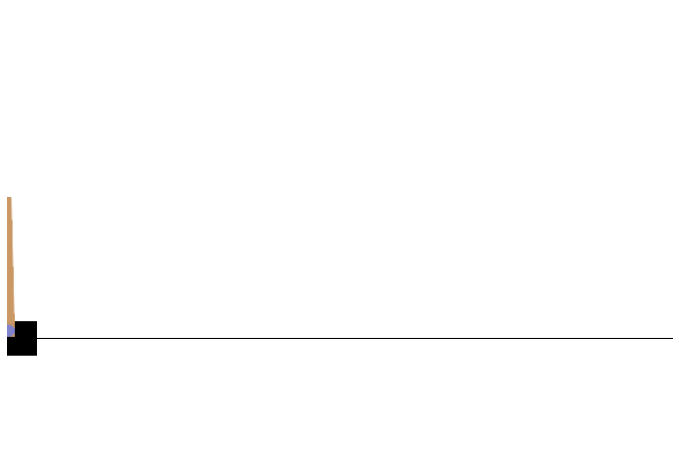

In [218]:
trajectory = get_trajectory(env, policy, visualize=True)
print(sum(trajectory["rewards"]))

In [327]:
validation(env, policy, deterministic=True)

110.15

### A2C

In [16]:
class MlpCritic(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, input):
        return self.net(input)

In [17]:
def get_1_step_td_advantage(rewards, values, terminated, gamma=1):
    targets = rewards[:-1] + gamma * (~terminated[:-1]) * values[1:]
    advantages = targets - values[:-1]
    return targets, advantages

In [18]:
def get_max_step_advantage(rewards, values, terminated, gamma=1):
    returns = get_returns(rewards, terminated)
    targets = returns[:-1]
    advantages = targets - values[:-1]
    return targets, advantages

In [19]:
def a2c_loss(data, critic, advantage_fn):
    loss = {}

    log_probs = data["log_probs"][:-1]

    observations = data["observations"]
    values = critic(observations).squeeze()
    targets = data["q_estimations"]
    advantages = targets[:-1].detach() - values[:-1]

    loss["actor"] = -(log_probs * advantages.detach()).mean()
    loss["critic"] = (advantages**2).mean()

    return loss

In [20]:
def a2c(
    env: gym.Env,
    actor: DiscreteStochasticMlpPolicy,
    critic: MlpCritic,
    actor_optimizer,
    critic_optimizer,
    total_timesteps: int = 100_000,
    # rollout_size: int = 200,
    trajectories_n: int = 10,
    advantage_fn: callable = get_max_step_advantage,
):
    buffer = RolloutBuffer()
    logger = Logger()

    steps_n = 0
    while steps_n < total_timesteps:

        buffer.collect_rollouts(env, actor, trajectories_n=trajectories_n)

        data = buffer.get_data()

        rollout_size = data["observations"].shape[0]
        steps_n += rollout_size

        loss = a2c_loss(data, critic, advantage_fn)

        logger.log(steps_n, data)

        loss["actor"].backward()
        actor_optimizer.step()
        actor_optimizer.zero_grad()

        loss["critic"].backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()

In [21]:
actor = DiscreteStochasticMlpPolicy(input_size, output_size)
critic = MlpCritic(input_size)

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-4)

In [22]:
a2c(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=50_000)

steps_n: 1164
mean_trajectory_rewards: 19.799999237060547
mean_trajectory_length: 19.80000114440918
steps_n: 2063
mean_trajectory_rewards: 21.899999618530273
mean_trajectory_length: 21.899999618530273
steps_n: 3107
mean_trajectory_rewards: 33.5
mean_trajectory_length: 33.5
steps_n: 4041
mean_trajectory_rewards: 19.0
mean_trajectory_length: 19.0
steps_n: 5204
mean_trajectory_rewards: 30.5
mean_trajectory_length: 30.5
steps_n: 6073
mean_trajectory_rewards: 22.100000381469727
mean_trajectory_length: 22.100000381469727
steps_n: 7059
mean_trajectory_rewards: 21.100000381469727
mean_trajectory_length: 21.100000381469727
steps_n: 8085
mean_trajectory_rewards: 28.799999237060547
mean_trajectory_length: 28.80000114440918
steps_n: 9032
mean_trajectory_rewards: 19.899999618530273
mean_trajectory_length: 19.899999618530273
steps_n: 10020
mean_trajectory_rewards: 23.799999237060547
mean_trajectory_length: 23.80000114440918
steps_n: 11072
mean_trajectory_rewards: 22.5
mean_trajectory_length: 22.5
st

In [391]:
validation(env, actor, deterministic=True)

360.35

In [241]:
validation(env, actor, deterministic=False)

58.95

### PPO

In [23]:
def ppo_loss(
    data,
    actor,
    critic,
    epsilon: float = 0.3,
    advantage_normalization: bool = True,
    rewards_normalization: bool = True,
):
    loss = {}

    old_log_probs = data["log_probs"][:-1]

    observations = data["observations"]
    _, new_log_probs = actor.predict(observations[:-1])

    ratio = torch.exp(new_log_probs - old_log_probs.detach())
    ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)

    values = critic(observations).squeeze()

    targets = data["q_estimations"]
    advantages = targets[:-1].detach() - values[:-1]

    actor_loss_1 = ratio * advantages.detach()
    actor_loss_2 = ratio_clipped * advantages.detach()

    loss["actor"] = -(torch.min(actor_loss_1, actor_loss_2)).mean()
    loss["critic"] = (advantages**2).mean()

    return loss

In [24]:
def ppo(
    env: gym.Env,
    actor: DiscreteStochasticMlpPolicy,
    critic: MlpCritic,
    actor_optimizer,
    critic_optimizer,
    total_timesteps: int = 100_000,
    trajectories_n: int = 10,
    epoch_n: int = 3,
    batch_size: int = 256,
    advantage_fn: callable = get_max_step_advantage,
):
    buffer = RolloutBuffer()
    logger = Logger()

    steps_n = 0
    while steps_n < total_timesteps:

        buffer.collect_rollouts(env, actor, trajectories_n=trajectories_n)

        data = buffer.get_data()

        rollout_size = data["observations"].shape[0]
        steps_n += rollout_size

        for _ in range(epoch_n):
            indices = np.random.permutation(range(rollout_size))

            for start in range(0, rollout_size, batch_size):
                end = start + batch_size
                batch_indices = indices[start:end]

                if batch_indices.size <= 1:
                    break

                batch = {key: value[batch_indices] for key, value in data.items()}

                loss = ppo_loss(batch, actor, critic)

                loss["actor"].backward()
                actor_optimizer.step()
                actor_optimizer.zero_grad()

                loss["critic"].backward()
                critic_optimizer.step()
                critic_optimizer.zero_grad()
                
        logger.log(steps_n, data)

In [25]:
actor = DiscreteStochasticMlpPolicy(input_size, output_size)
critic = MlpCritic(input_size)

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-4)

In [26]:
ppo(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=100_000)

steps_n: 1019
mean_trajectory_rewards: 23.899999618530273
mean_trajectory_length: 23.899999618530273
steps_n: 2229
mean_trajectory_rewards: 25.399999618530273
mean_trajectory_length: 25.399999618530273
steps_n: 3092
mean_trajectory_rewards: 20.399999618530273
mean_trajectory_length: 20.399999618530273
steps_n: 4122
mean_trajectory_rewards: 22.399999618530273
mean_trajectory_length: 22.399999618530273
steps_n: 5204
mean_trajectory_rewards: 22.399999618530273
mean_trajectory_length: 22.399999618530273
steps_n: 6017
mean_trajectory_rewards: 25.299999237060547
mean_trajectory_length: 25.30000114440918
steps_n: 7091
mean_trajectory_rewards: 22.399999618530273
mean_trajectory_length: 22.399999618530273
steps_n: 8026
mean_trajectory_rewards: 20.899999618530273
mean_trajectory_length: 20.899999618530273
steps_n: 9077
mean_trajectory_rewards: 28.399999618530273
mean_trajectory_length: 28.399999618530273
steps_n: 10074
mean_trajectory_rewards: 26.600000381469727
mean_trajectory_length: 26.600000

In [369]:
batch["q_estimations"]

tensor([ 1.,  8., 11.,  3.,  7., 14.,  6., 17.,  8.,  2.,  6.,  3.,  3.,  2.,
         5.,  9.,  9.,  5., 17.,  7.,  3.,  6., 13.,  5.,  4., 11.,  7.,  4.,
        10., 24.,  9., 12.,  8., 11.,  8.,  4.,  7., 10., 11.,  3., 34., 15.,
         2., 15., 17.,  5.,  8.,  9.,  4., 19., 16., 16., 21.,  3., 12., 10.,
         6., 20.,  8., 12.,  7., 16., 20.,  4., 15.,  9.,  3., 14.,  9., 10.,
         1.,  2., 13., 11., 17., 22.,  2., 27.,  1.,  2.,  2., 14.,  7., 35.,
         1., 12.,  2.,  7.,  9., 20., 11., 15., 10.,  6., 11.,  2.,  3.,  9.,
        19.,  1.,  1.,  6.,  8., 12., 19.,  6.,  3.,  5.,  8.,  9., 12.,  8.,
        13., 14.,  5.,  8., 22.,  4., 13., 17., 30., 11., 12.,  5., 15., 16.,
        10.,  8., 25.,  7.,  2., 14.,  5.,  5.,  5.,  7., 32., 15.,  2.,  9.,
         3.,  1.,  7., 18., 10., 17.,  1.,  6.,  1.,  4., 10., 13.,  8., 19.,
         8., 13.,  6., 37., 11.,  3.,  1., 21.,  3.,  2., 18.,  8., 10., 39.,
        11., 15.,  2., 10.,  2., 12.,  6., 14.,  4., 15.,  3.,  

In [408]:
batch["observations"].shape[0]

256

In [370]:
critic(batch["observations"]).squeeze()

tensor([-0.2666, -0.0473, -0.1145, -0.0358, -0.0603, -0.1464, -0.1577, -0.1342,
        -0.1583, -0.2862, -0.2080, -0.1062, -0.2603, -0.0448, -0.1917, -0.0853,
        -0.0522, -0.0389, -0.1201, -0.1180, -0.0116, -0.2338, -0.0495, -0.0491,
        -0.1637, -0.0426, -0.0702, -0.0492, -0.1224, -0.1968, -0.1240, -0.0979,
        -0.0500, -0.0623, -0.0545, -0.1392, -0.2119, -0.0675, -0.1242, -0.0420,
        -0.1187, -0.0750, -0.1046, -0.1210, -0.1183, -0.0417, -0.1088, -0.0444,
        -0.0416, -0.1194, -0.1264, -0.0805, -0.1270, -0.1964, -0.0307, -0.1429,
        -0.0300, -0.0865, -0.0381, -0.0484, -0.0472, -0.1483, -0.0901, -0.0357,
        -0.0684, -0.0254, -0.2776, -0.1946, -0.0658, -0.0325, -0.2860, -0.0307,
        -0.0686, -0.0662, -0.2015, -0.1234, -0.2574, -0.1603,  0.0066, -0.0145,
        -0.0421, -0.0443, -0.2203, -0.1493, -0.0307, -0.0687, -0.0017, -0.0988,
        -0.2162, -0.0860, -0.2111, -0.1224, -0.0933, -0.0966, -0.0967, -0.0135,
        -0.0046, -0.0566, -0.1214, -0.03

In [368]:
batch["q_estimations"]

tensor([ 1.,  8., 11.,  3.,  7., 14.,  6., 17.,  8.,  2.,  6.,  3.,  3.,  2.,
         5.,  9.,  9.,  5., 17.,  7.,  3.,  6., 13.,  5.,  4., 11.,  7.,  4.,
        10., 24.,  9., 12.,  8., 11.,  8.,  4.,  7., 10., 11.,  3., 34., 15.,
         2., 15., 17.,  5.,  8.,  9.,  4., 19., 16., 16., 21.,  3., 12., 10.,
         6., 20.,  8., 12.,  7., 16., 20.,  4., 15.,  9.,  3., 14.,  9., 10.,
         1.,  2., 13., 11., 17., 22.,  2., 27.,  1.,  2.,  2., 14.,  7., 35.,
         1., 12.,  2.,  7.,  9., 20., 11., 15., 10.,  6., 11.,  2.,  3.,  9.,
        19.,  1.,  1.,  6.,  8., 12., 19.,  6.,  3.,  5.,  8.,  9., 12.,  8.,
        13., 14.,  5.,  8., 22.,  4., 13., 17., 30., 11., 12.,  5., 15., 16.,
        10.,  8., 25.,  7.,  2., 14.,  5.,  5.,  5.,  7., 32., 15.,  2.,  9.,
         3.,  1.,  7., 18., 10., 17.,  1.,  6.,  1.,  4., 10., 13.,  8., 19.,
         8., 13.,  6., 37., 11.,  3.,  1., 21.,  3.,  2., 18.,  8., 10., 39.,
        11., 15.,  2., 10.,  2., 12.,  6., 14.,  4., 15.,  3.,  

In [398]:
validation(env, actor, deterministic=True)

9.1

In [181]:
from stable_baselines3 import PPO

In [184]:
agent = PPO("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
agent.learn(100_000)

In [41]:
validation(env, actor, deterministic=True)

9.15

In [65]:
validation(env, actor, deterministic=False)

20.7

In [294]:
rb = RolloutBuffer()

In [295]:
rb.collect_rollouts(env, actor, trajectories_n=3)

In [296]:
obs, _ = env.reset()
probs = actor.forward(obs)

In [297]:
obs

array([-0.0178676 , -0.03208   , -0.01955283,  0.04398148], dtype=float32)

In [298]:
input = torch.FloatTensor(obs.reshape(-1, actor.obs_dim))
output = actor.act(actor.fc1(input))
output = actor.act(actor.fc2(output))
logits = actor.fc3(output)

In [299]:
output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0728,
         0.2238, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1319, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)

In [300]:
logits

tensor([[-0.0106,  0.0015]], grad_fn=<AddmmBackward0>)

In [301]:
probs

tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward0>)

In [302]:
data = rb.get_data()

In [303]:
data["terminated"]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False,  True])

In [304]:
loss = {}
epsilon = 0.1
old_log_probs = data["log_probs"][:-1]

observations = data["observations"]
_, new_log_probs = actor.predict(observations[:-1])

In [305]:
ratio = torch.exp(new_log_probs - old_log_probs.detach())
ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)

In [306]:
ratio

tensor([1.0000, 1.0000, 1.0162, 1.0000, 0.9844, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9783, 0.9881, 1.0121,
        0.9880, 0.9880, 0.9834, 1.0223, 1.0163, 0.9890, 0.9844, 1.0000, 1.0000,
        0.9801, 1.0000, 1.0000, 1.0000, 1.0181, 1.0118, 1.0000, 0.9885, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0244, 1.0000, 1.0000, 1.0000],
       grad_fn=<ExpBackward0>)

In [307]:
ratio_clipped

tensor([1.0000, 1.0000, 1.0162, 1.0000, 0.9844, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9783, 0.9881, 1.0121,
        0.9880, 0.9880, 0.9834, 1.0223, 1.0163, 0.9890, 0.9844, 1.0000, 1.0000,
        0.9801, 1.0000, 1.0000, 1.0000, 1.0181, 1.0118, 1.0000, 0.9885, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0244, 1.0000, 1.0000, 1.0000],
       grad_fn=<ClampBackward1>)

In [308]:
rewards = data["rewards"]
terminated = data["terminated"]

values = critic(observations).squeeze()

In [309]:
returns = get_returns(rewards, terminated)
advantages = returns[:-1] - values[:-1]

In [310]:
observations.shape, advantages.shape

(torch.Size([44, 4]), torch.Size([43]))

In [311]:
returns

tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,
         5.,  4.,  3.,  2.,  1., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1.])

In [312]:
advantages

tensor([ -2.3278,  -3.4338,  -5.0032,  -5.4325,  -6.8733,  -7.8434,  -8.6129,
         -9.2907, -10.4307, -11.2181, -12.2135, -12.1152, -10.9649, -12.3075,
        -10.9311,  -9.3239,  -1.3634,  -2.3534,  -3.3723,  -4.3511,  -5.8654,
         -7.0074,  -7.6689,  -8.3411,  -9.5152, -10.3506, -10.3001, -11.6120,
        -10.8306, -12.1843, -10.9931, -12.2267, -13.4220,  -7.4125,  -8.3714,
         -9.6782, -10.5685, -10.6768,  -9.6708, -11.1053, -12.4615, -11.2891,
        -12.5376], grad_fn=<SubBackward0>)

In [ ]:

if advantage_normalization:
    mean = advantages.mean()
    std = advantages.std()
    advantages = (advantages - mean) / (std + 1e-8)

actor_loss_1 = ratio * advantages.detach()
actor_loss_2 = ratio_clipped * advantages.detach()

loss["actor"] = -(torch.min(actor_loss_1, actor_loss_2)).mean()
loss["critic"] = (advantages**2).mean()


In [343]:
data["observations"].shape

torch.Size([1000, 4])

In [139]:
actor.predict(data["observations"])

(0,
 tensor([-0.6961, -0.6966, -0.6961, -0.6818, -0.7037, -0.6809, -0.6898, -0.6955,
         -0.6967, -0.6954, -0.6969, -0.6909, -0.7077, -0.7125, -0.6773, -0.6961,
         -0.7109, -0.6755, -0.6750, -0.6760, -0.6729, -0.6862, -0.6920, -0.6853,
         -0.6922, -0.7015, -0.6924, -0.6999, -0.6940, -0.6837, -0.6938, -0.6827,
         -0.6735, -0.7054, -0.7124, -0.7094, -0.7076, -0.6774, -0.6890, -0.6917,
         -0.6889, -0.6802, -0.6802, -0.6802, -0.6978, -0.6922, -0.6978, -0.6802,
         -0.6980, -0.7062, -0.6981, -0.7061, -0.6788, -0.6805, -0.6879, -0.6938,
         -0.6810, -0.6940, -0.6880, -0.7059, -0.6877, -0.7059, -0.6990, -0.6806,
         -0.6870, -0.6942, -0.6866, -0.7059, -0.6860, -0.6951, -0.6792, -0.6769,
         -0.6781, -0.6883, -0.7012, -0.7014, -0.6766, -0.6779],
        grad_fn=<SqueezeBackward1>))

In [442]:
deterministic = True
input = data["observations"][0]
probs = actor.forward(input)
dist = Categorical(probs)

if deterministic:
    action = torch.argmax(probs, dim=1)
else:
    action = dist.sample()

log_prob_action = dist.log_prob(action)

In [443]:
probs

tensor([[0.5269, 0.4731]], grad_fn=<SoftmaxBackward0>)

In [444]:
torch.argmax(probs, dim=1)

tensor([0])

In [445]:
action[0].item()

0

In [446]:
action.squeeze().numpy()

array(0, dtype=int64)

In [434]:
action.item()

0

In [370]:
idxs = [1, 2, 3]
data["observations"][idxs]


tensor([[-0.0266, -0.1906,  0.0273,  0.2716],
        [-0.0304,  0.0042,  0.0327, -0.0124],
        [-0.0303,  0.1988,  0.0325, -0.2946]])

In [267]:
sum(data["rewards"])

tensor(1000.)

In [ ]:
dones = data["terminated"] + data["truncated"]
if sum(dones) == 0:
    dones[-1] = True
dones_indeces = dones.nonzero()
last_done_index = dones_indeces[-1][0].item()
trajectory_n = sum(dones)
mean_trajectory_rewards = sum(data["rewards"][:last_done_index]) / trajectory_n
mean_trajectory_length = last_done_index / trajectory_n

In [245]:
sum(data["terminated"])

tensor(6)

In [265]:
logger.log(1001, data)

steps_n: 1001
mean_trajectory_rewards: 35.10714340209961
mean_trajectory_length: 35.10714340209961


In [132]:
logger = Logger(4)

In [133]:
logger.log(5, data)

steps_n: 5
mean_trajectory_rewards: 4.0
mean_trajectory_length: 4.0


In [134]:
data["terminated"]

tensor([False, False, False, False, False])

In [210]:
sum(data["truncated"])

tensor(1)

In [211]:
sum(data["terminated"] + data["truncated"])

tensor(4)

In [268]:
dones = data["terminated"] + data["truncated"]
dones_indeces = dones.nonzero()
last_done_index = dones_indeces[-1][0].item()
trajectory_n = sum(dones)
mean_trajectory_rewards = sum(data["rewards"][:last_done_index]) / trajectory_n
mean_trajectory_length = last_done_index / trajectory_n

print(f"mean_trajectory_rewards: {mean_trajectory_rewards}")
print(f"mean_trajectory_length: {mean_trajectory_length}")


mean_trajectory_rewards: 35.10714340209961
mean_trajectory_length: 35.10714340209961


In [270]:
sum(data["terminated"])

tensor(28)

In [269]:
print(trajectory_n)

tensor(28)


In [231]:
mean_trajectory_length, mean_trajectory_rewards

(tensor(242.7500), tensor(242.7500))

In [242]:
data["observations"].shape[0]

1000